In [1]:
import sys
from pathlib import Path

In [4]:
project_root = str(Path.cwd().parent)  
if project_root not in sys.path:
    sys.path.append(project_root)
project_root

'/home/arpola/Documents/GalaxyClassifier'

In [18]:
import mlflow
from mlflow import MlflowClient
import torch
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from src.cnn import NeuralNet
from src.utils.general import get_dataset, get_data, get_project_root



In [6]:
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
mlflow.set_tracking_uri('http://localhost:5000')

In [7]:
model_name = "CNN_80"
model_version_alias = "1"
client.set_registered_model_alias(
    model_name, model_version_alias, "1"
)


In [8]:
model_info = client.get_model_version_by_alias(model_name, model_version_alias)
model_tags = model_info.tags
model_info

<ModelVersion: aliases=['1'], creation_timestamp=1752516672129, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1752516672129, metrics=None, model_id=None, name='CNN_80', params=None, run_id='', run_link='', source='mlflow-artifacts:/1/models/m-7b2de0fb278b41ccb7801287b87bb098/artifacts', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [9]:
model_uri = client.get_model_version_download_uri(model_name, model_version_alias)
model = mlflow.pytorch.load_model(model_uri)

/home/arpola/Documents/GalaxyClassifier/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [10]:
type(model)

cnn.NeuralNet

In [11]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
root_path = get_project_root()
images_path = root_path / 'data' / 'images.npy'
labels_path = root_path / 'data' / 'labels.npy'
images, labels = get_data()

# Create indices for test split
indices = np.arange(len(labels))
np.random.seed(42)
np.random.shuffle(indices)
train_size = int(0.7 * len(labels))
val_size = int(0.15 * len(labels))
test_indices = indices[train_size + val_size:]
_, test_dataset, _ = get_dataset(indices[:train_size], test_indices, indices[train_size:train_size + val_size], images_path, labels_path)

In [39]:

# Make prediction for test_dataset[40]
model.eval()
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 
               'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

# Get the 40th sample
sample_image, sample_label = test_dataset[40]

# Add batch dimension and move to device
sample_image = sample_image.unsqueeze(0).to(device)  # Shape: (1, 3, 256, 256)

# Perform prediction
with torch.no_grad():
    output = model(sample_image)  # Forward pass
    probabilities = F.softmax(output, dim=1)  # Convert to probabilities
    predicted_class = torch.argmax(probabilities, dim=1).item()  # Get predicted class index

# Print results
print(f"Predicted Class: {class_names[predicted_class]}")
print(f"True Class: {class_names[sample_label]}")
print(f"Probabilities: {probabilities.cpu().numpy()[0]}")

Predicted Class: Class 9
True Class: Class 9
Probabilities: [2.1537150e-04 5.4522563e-02 6.0326212e-05 2.4665148e-06 5.1036682e-07
 4.2135558e-01 3.9919670e-04 1.4198155e-03 3.5455669e-03 5.1847869e-01]


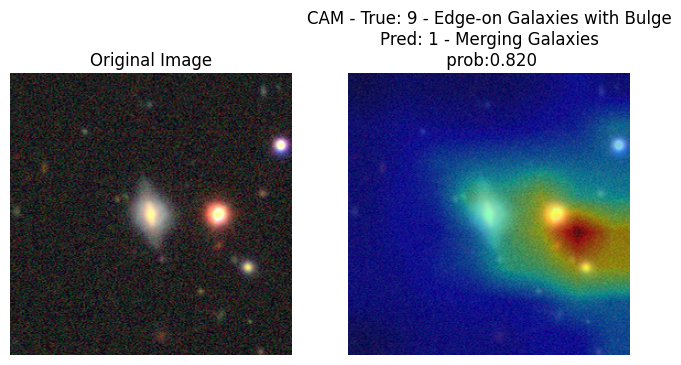

Predicted Class: 1 - Merging Galaxies
True Class: 9 - Edge-on Galaxies with Bulge
Probabilities: [3.0886028e-07 8.1960559e-01 1.1653766e-04 2.2748520e-08 2.7176254e-11
 1.0207765e-03 1.6005334e-01 1.4441870e-02 5.1543255e-05 4.7099032e-03]


In [136]:

# Class names (update with actual galaxy types if known)
class_names = [
    "0 - Disturbed Galaxies",
    "1 - Merging Galaxies",
    "2 - Round Smooth Galaxies",
    "3 - In-between Round Smooth Galaxies",
    "4 - Cigar Shaped Smooth Galaxies",
    "5 - Barred Spiral Galaxies",
    "6 - Unbarred Tight Spiral Galaxies",
    "7 - Unbarred Loose Spiral Galaxies",
    "8 - Edge-on Galaxies without Bulge",
    "9 - Edge-on Galaxies with Bulge"
]

# Class Activation Maps (CAM) with Prediction
def compute_cam_and_predict(model, image, target_class, device):
    model.eval()
    features = []
    def hook(module, input, output):
        features.append(output.detach())
    
    # Hook the last convolutional layer (conv6)
    layer = model.conv6
    handle = layer.register_forward_hook(hook)
    
    # Forward pass for prediction and CAM
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Compute CAM
    weights = model.fc3.weight[target_class].detach().cpu().numpy()
    feature_map = features[0][0].cpu().numpy()
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
    
    for i, w in enumerate(weights):
        cam += w * feature_map[i]
    
    # Normalize and resize
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-10)  # Avoid division by zero
    cam = cv2.resize(cam, (image.shape[3], image.shape[2]), interpolation=cv2.INTER_LINEAR)
    cam = np.uint8(255 * cam)
    
    handle.remove()
    return cam, predicted_class, probabilities.cpu().numpy()[0]

def plot_cam(image, cam, true_class, predicted_class, probabilities, class_names):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f'CAM - True: {class_names[true_class]}\nPred: {class_names[predicted_class]}\n prob:{probabilities[predicted_class]:.3f}')
    plt.axis('off')
    plt.savefig('cam_visualization.png')
    plt.show()
    
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"True Class: {class_names[true_class]}")
    print(f"Probabilities: {probabilities}")

# Compute and plot CAM with prediction for a sample image
sample_image, sample_label = test_dataset[1111]
cam, predicted_class, probabilities = compute_cam_and_predict(model, sample_image, sample_label, device)
plot_cam(sample_image, cam, sample_label, predicted_class, probabilities, class_names)